# FGSM attack on MNIST/ImageNet
Author: Xuechao Zhang  
Date: May 17th, 2022  
Description: FGSM(Fast Gradient Sign Attack) attack,
            a white-box attack with the goal of misclassification.  
Reference: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

## Start

In [1]:
from __future__ import print_function
import sys
import os
os.chdir(sys.path[0])  # 当前文件目录
# sys.path.insert(0, os.path.split(__file__)[0])
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Inputs
选择数据集和预训练的模型:  
MNIST (LeNet) or ImageNet (MobileNet V2)

In [2]:
# 进行测试的epsilon值; 0表示未进行攻击时的检测结果; 注意原始数据范围[0,1]
epsilons = [0, .05, .1, .15, .2, .25, .3]

# 是否使用GPU  Define what device we are using
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# 数据集和模型
dataset = 'ImageNet'  # 'MNIST' or 'ImageNet'
if dataset == 'MNIST':
    from MNIST_model import Net, Data
elif dataset == 'ImageNet':
    from ImageNet_model import Net, Data
else:
    raise ValueError("dataset must be MNIST or ImageNet")

model = Net().to(device)
test_loader = Data()

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## FGSM Attack
定义对抗样本的生成方法

In [3]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    # loss对x的梯度方向
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    # 根据梯度方向和epsilon值, 调整图像的每个像素
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    # 将图像的像素值限制在[0,1]范围内
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## Testing Function
关键函数：调用时，对于test set里的每一张样本，计算loss对输入样本的梯度，根据攻击强度ε生成对抗样本，最后检查结果。

In [4]:
def test(model, device, test_loader, epsilon, test_count = 10000):
    """
    test_count: 测试图片数量
    """

    # Accuracy counter
    correct = 0
    adv_examples = []
    tested_count = 0

    # 遍历 Loop over all examples in test set
    for data, target in test_loader:

        # 移到显卡 Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # 设置对样本求梯度 Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # 正向计算拿到预测 Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # 预测都错了就不管了 If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # (某种loss) Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # 开始计算梯度 Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # 梯度方向*ε生成对抗样本 Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # 检查是否成功 保留前五个 Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        
        tested_count+=1
        if tested_count >= test_count:
            break

    # 计算正确率 Calculate final accuracy for this epsilon
    final_acc = correct/float(test_count)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, test_count, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## Run Attack

根据epsilon列表，跑测试。

In [5]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, test_count=500)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 500 / 500 = 1.0
Epsilon: 0.05	Test Accuracy = 489 / 500 = 0.978
Epsilon: 0.1	Test Accuracy = 419 / 500 = 0.838
Epsilon: 0.15	Test Accuracy = 346 / 500 = 0.692
Epsilon: 0.2	Test Accuracy = 210 / 500 = 0.42
Epsilon: 0.25	Test Accuracy = 98 / 500 = 0.196
Epsilon: 0.3	Test Accuracy = 47 / 500 = 0.094


## Results
结果分析
1. Accuracy vs Epsilon
2. Sample Adversarial Examples

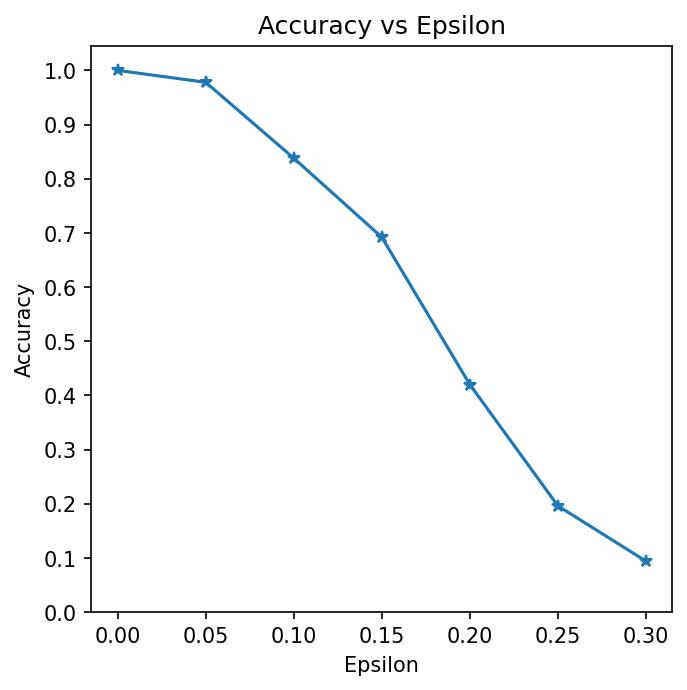

In [6]:
%config InlineBackend.figure_format = 'jpg'  # 强制白底
plt.figure(dpi=150, figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

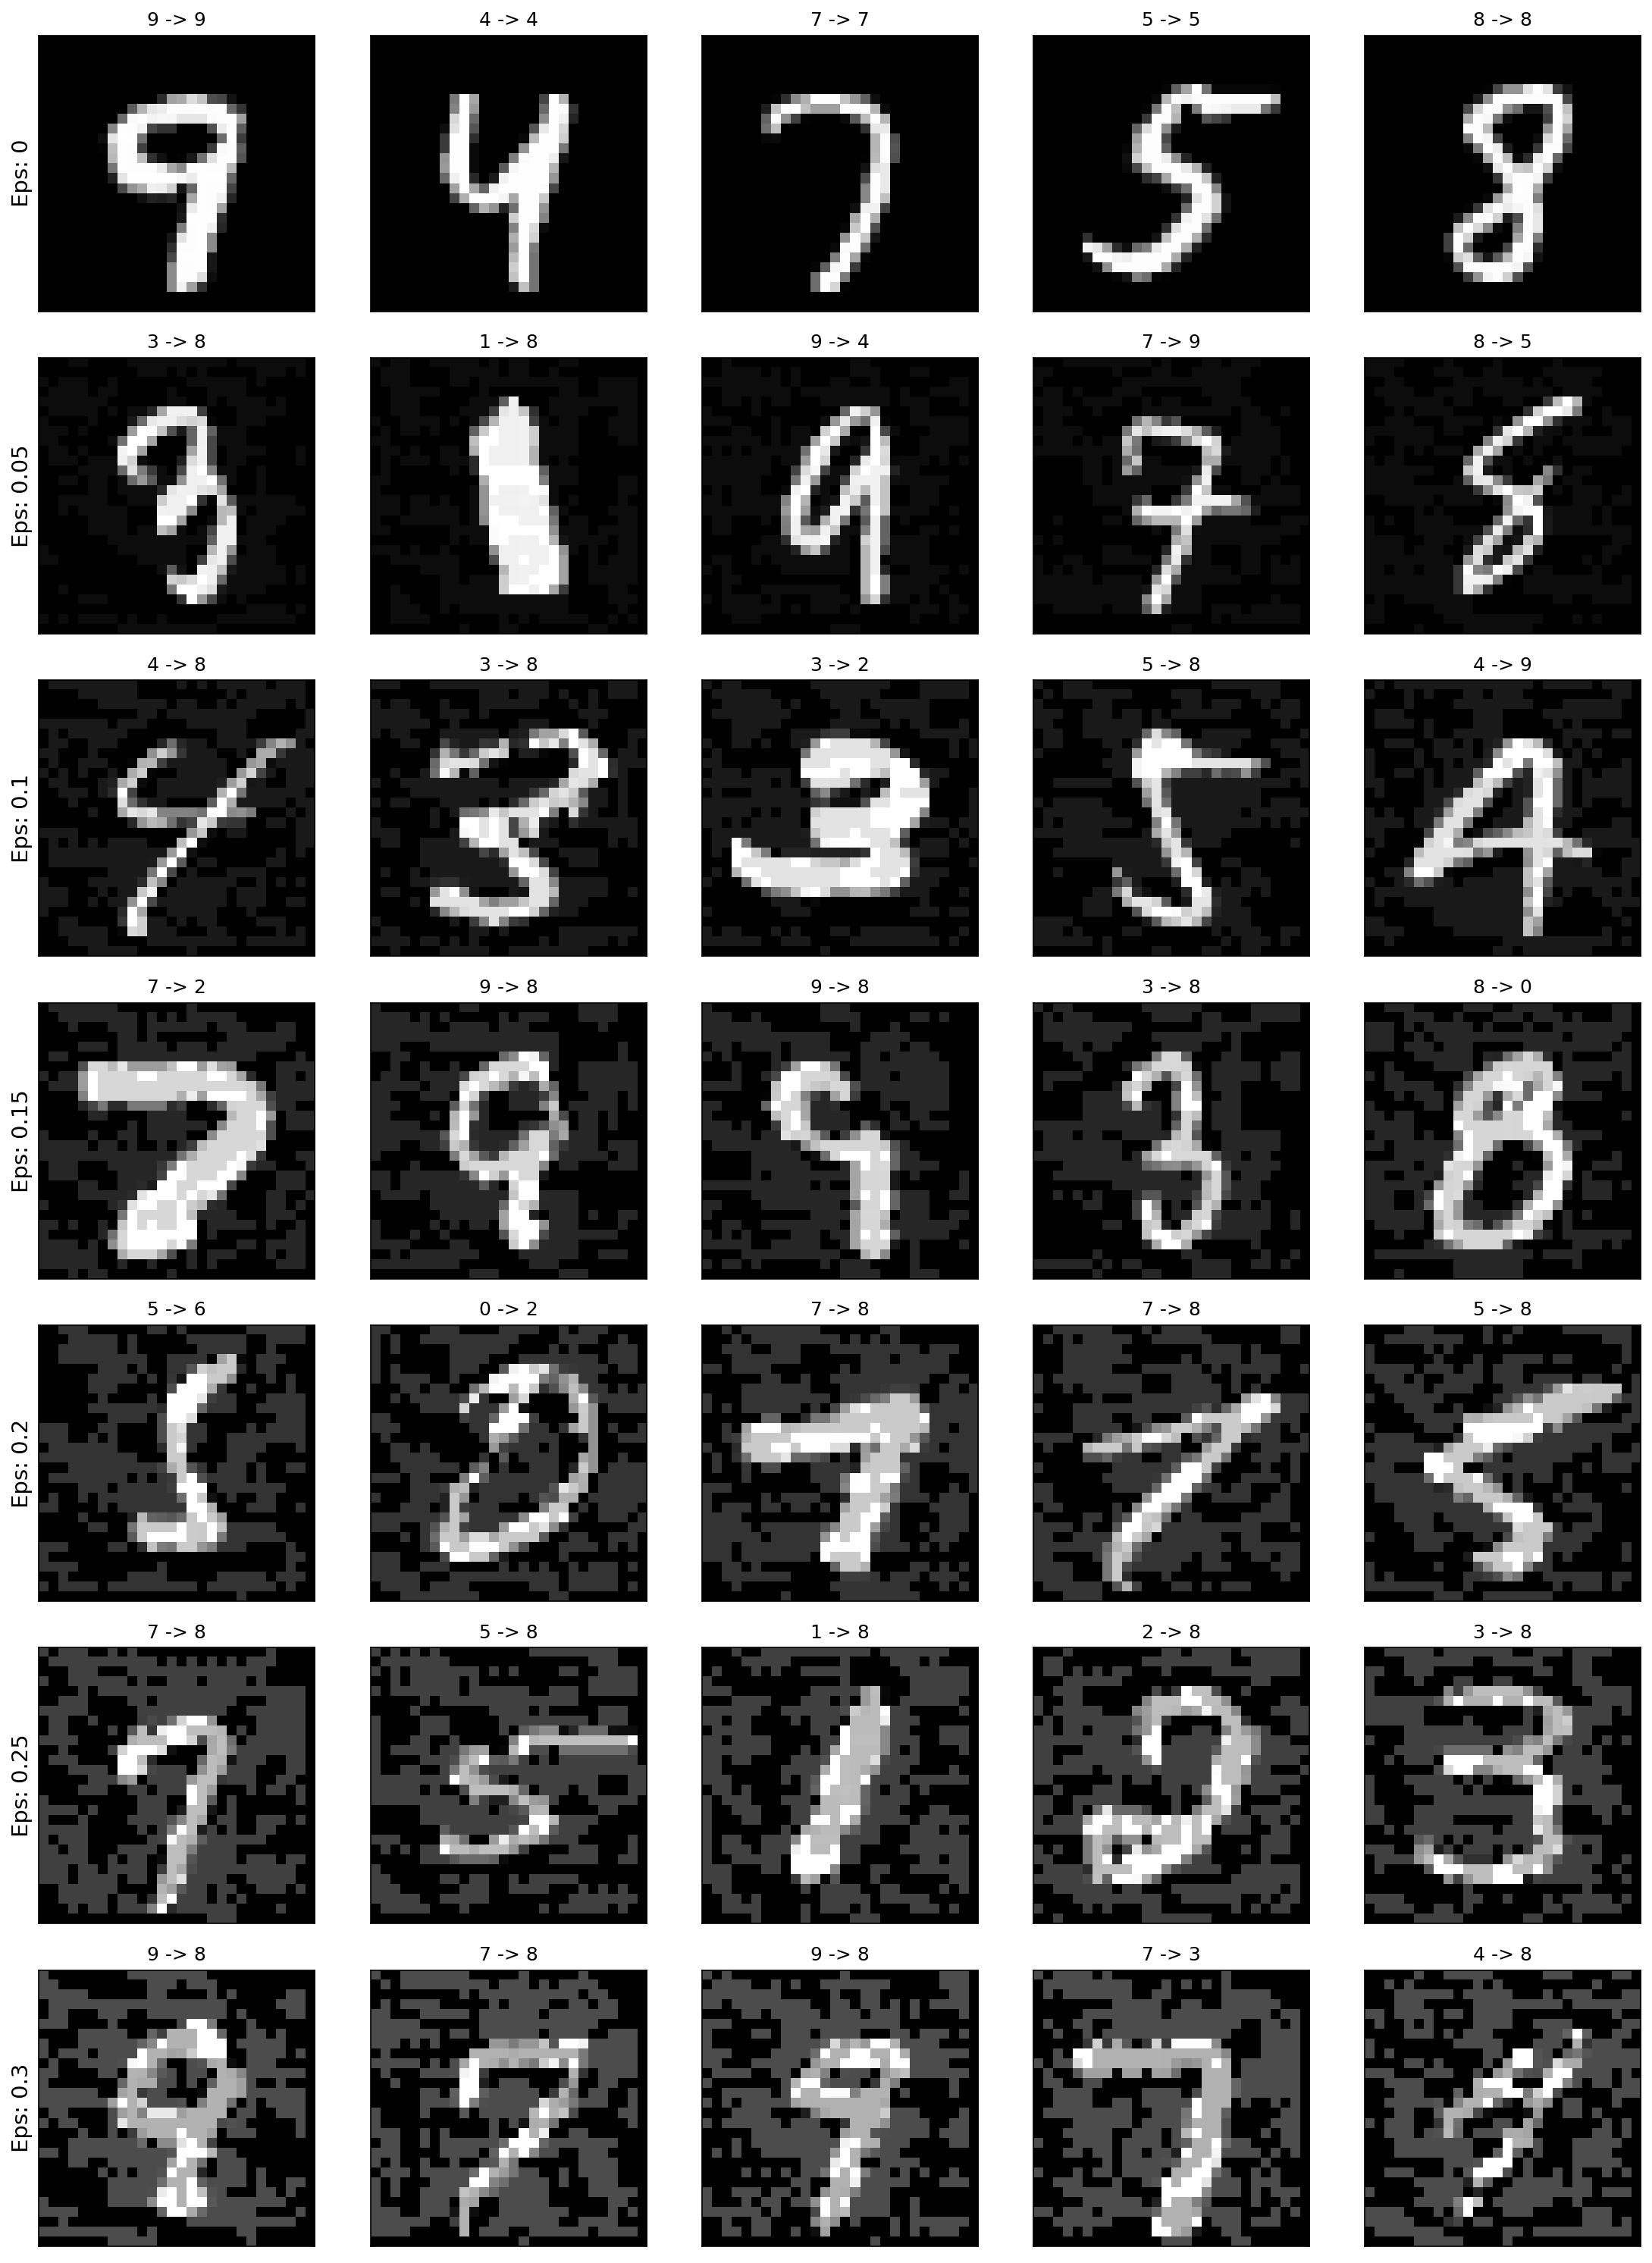

In [7]:
# %config InlineBackend.figure_format = 'jpg'  # 强制白底
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(dpi=150, figsize=(15,20))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        if dataset == 'ImageNet':
            # 从label数值转到class name
            with open("imagenet_classes.txt", "r") as f:
                categories = [s.strip() for s in f.readlines()]
            orig = categories[orig]
            adv = categories[adv]
            # 针对plt显示tensor做一些处理 ref:https://zhuanlan.zhihu.com/p/424638008
            ex = ex.swapaxes(0, 1)
            ex = ex.swapaxes(1, 2)
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
        # plt.imshow(ex)
plt.tight_layout()
plt.show()